## Term project - Seniment analysis of Hungarian poetry

#### Description and research questions

In this project I will analyize a sample of the hungarian poetry to anwser the following questions:

Q1. Sentiment analysis:
- What is the general sentiment of Hungarian poetry?
- Which of our authors are the most cheerfull and which ones are the most gloomy?
- Is there a trend in time of the sentiment changing?

Q2. Classifiation:
- Can poetry be classified using a Naive-Bayes algoryth?

#### Data used

ELTE, a hungarian university collected poems from the most popular hungarian authors and collected them on this website (https://verskorpusz.elte-dh.hu/view.php?id=3051)

#### Table of content

During the project I did the following main steps:
- Creating the dataframes: scraping the poems and the year of birth of the authors
- Exploring the data: checking missing data, excluding too long poems, checking data type of columns, checking key distributions and value counts
- Q1: Sentiment analysis: cleaning the hungarian text (punctuation, non-letter characters, stopwords, lower casing), translating it to english via google translator function, cleaning again, lemmatizing and sentiment analysis per century and per author
- Q2: Classification via Naive-Bayes and evaluation with confusion matrix for 3 top authors

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1. Creating the dataframes

#### 1.1 Loading the dataset

I loaded the dataset that I downloaded (https://verskorpusz.elte-dh.hu/view.php?id=3051) into Jupiter. 

- The dataset has c.13.000 rows, and each row is a poem.
- The dataset has 3 columns: author, title of the poem, and an url to the poem text

In [2]:
df = pd.read_csv("./talalatok.tsv", sep='\t')
df = pd.DataFrame(df)
df = df.rename(columns={"Szerző":"author", "Műcím":"title", "Webcím":"url"})
df

,author,title,url
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325
...,...,...,...
13059,Zrínyi Miklós,NEM IROM PENNÁVAL...,https://verskorpusz.elte-dh.hu/view.php?id=5486
13060,Zrínyi Miklós,PERORATIO,https://verskorpusz.elte-dh.hu/view.php?id=5474
13061,Zrínyi Miklós,RADIVOJ ÉS JURANICS VAJDÁK,https://verskorpusz.elte-dh.hu/view.php?id=5478
13062,Zrínyi Miklós,Szigeti veszedelem,https://verskorpusz.elte-dh.hu/view.php?id=5473


Let's check the number of poems per artist. We see a very uneven distribution with a long right tale: Some authory have less than 10 poems in the dataset while a few have over 500. Looking at these authors, the reason for this is that some that have a few poem are either writers and not poets, or from 16-17th century, with little known poems.

<AxesSubplot:title={'center':'Poems by author'}>

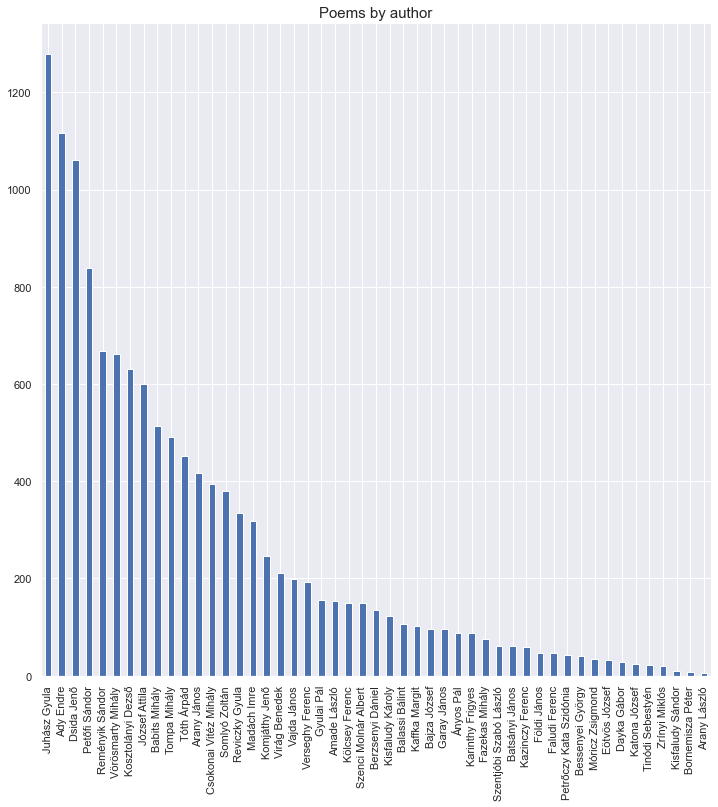

In [3]:
plt.figure(figsize=(12,12))
plt.title("Poems by author",fontsize=15)
df['author'].value_counts()[0:50].plot(kind='bar')

#### 1.2 Creating authors dataframe to scrape their year of birth

I needed to scrape the year of birth of each author to do an analysis on how sentiment changed through time (scraping the year of publishing per poem is not possible unfortunately, as this data is not available in a structured manner for scraping). I created a separate dataframe with the authors only, and the number of the poems they wrote.

In [4]:
authors = df[["author", "url"]].groupby("author").count().sort_values(['url'], ascending=[False])
authors.reset_index(inplace=True)
authors

,author,url
0,Juhász Gyula,1278
1,Ady Endre,1116
2,Dsida Jenő,1060
3,Petőfi Sándor,839
4,Reményik Sándor,667
5,Vörösmarty Mihály,662
6,Kosztolányi Dezső,630
7,József Attila,599
8,Babits Mihály,514
9,Tompa Mihály,491


#### 1.3 Scraping the birth year of authors

I included the date of birth into this table by scraping the name of authors from google and extracting the date of birth fom the search result

In [5]:
def find_year(author):
    headers = {'Cookie':'CONSENT=YES+cb.20210418-17-p0.it+FX+917;'}
    url = ("https://www.google.com/search?q={}+született".format(author))
    resp = requests.get(url, headers = headers)
    soup = BeautifulSoup(resp.text, 'html.parser')
    year = soup.find_all("div", class_="BNeawe iBp4i AP7Wnd")[1].text[0:4]
    return year

In [6]:
# scraping and cheking the result

# authors["birth"] = authors["author"].apply(lambda x: find_year(x))
# authors

There are 2 missing years where the scraping did not work, I will impute these manually and save the dataset locally so I do not have to do the scraping again

In [7]:
# authors.at[38,'birth'] = 1658
# authors.at[44,'birth'] = 1510


In [8]:
# authors.to_csv('./authors.csv', index=False)

In [9]:
authors = pd.read_csv("./authors.csv")
authors

,author,url,birth
0,Juhász Gyula,1278,1883
1,Ady Endre,1116,1877
2,Dsida Jenő,1060,1907
3,Petőfi Sándor,839,1823
4,Reményik Sándor,667,1890
5,Vörösmarty Mihály,662,1800
6,Kosztolányi Dezső,630,1885
7,József Attila,599,1905
8,Babits Mihály,514,1883
9,Tompa Mihály,491,1817


#### 1.4 Scraping the poems

Since there are 13000 poems in the dataset, and one poem could has 3-400 words at least. That would be a too large dataset to handle. So for the sake of simplicity, I will take a sample of the original dataset. But I will also need to make sure I have a sample from all autohrs. So I randomly select either 30% of poems from each author or 6 of the poems they have less than 18

Taking a sample from the whole dataset and saving it locally:

In [10]:
#import random

#df_sample = df[0:0] # creating empty dataframe   

# getting at lest 10 poems from each author (to make sure we have samples from all centuries)

#for author in authors["author"]:                                 
#        if len(df[df["author"] == author]["url"]) < 18:
#               threshold = 6
#        else:
#               threshold = round(len(df[df["author"] == author]["url"])*0.3)
#        df_sample = df_sample.append(df[df["author"] == author].sample(n=threshold))

In [11]:
# df_sample.to_csv('./df_sample.csv', index=False)

In [12]:
df_sample = pd.read_csv("./df_sample.csv")

<AxesSubplot:title={'center':'Poems by author'}>

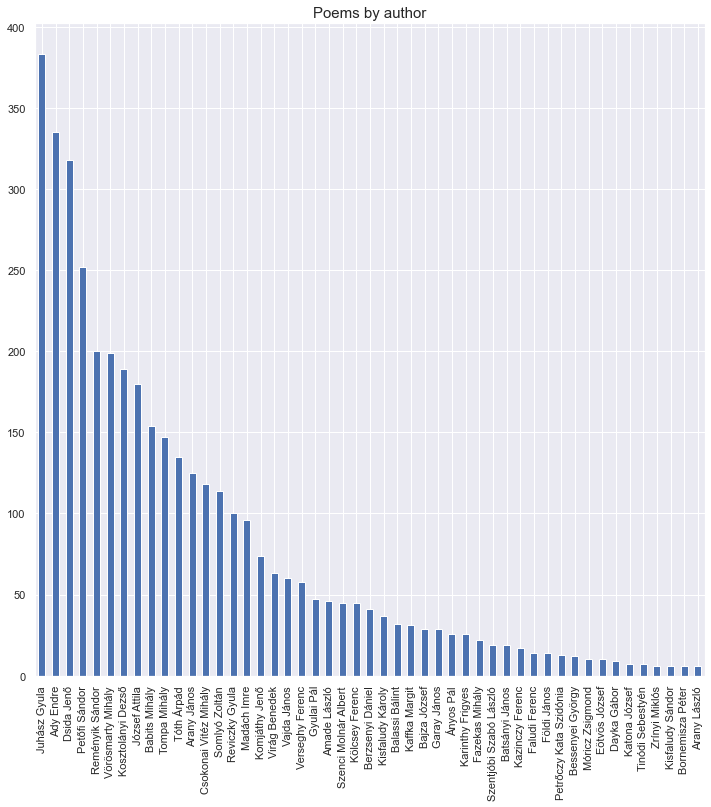

In [13]:
plt.figure(figsize=(12,12))
plt.title("Poems by author",fontsize=15)
df_sample['author'].value_counts()[0:50].plot(kind='bar')

In [14]:
print(df_sample.url.count())
df_sample.groupby("author").count().sort_values(['url'], ascending=[False])

3931


,title,url,poem
author,,,
Juhász Gyula,383,383,383
Ady Endre,335,335,335
Dsida Jenő,318,318,318
Petőfi Sándor,252,252,252
Reményik Sándor,200,200,200
Vörösmarty Mihály,199,199,199
Kosztolányi Dezső,189,189,189
József Attila,180,180,180
Babits Mihály,154,154,154


Scraping the poems and saving them locally:

In [17]:
#poems = []
#poem = []


#for url in df_sample["url"]:
#    poem=[]
#    print(url)
#    try:
#        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
#        for word in soup.find_all('span', class_='word'):
#            poem.append(word.text)
#        poems.append(" ".join(poem))
#    except:
#        poems.append("")

https://verskorpusz.elte-dh.hu/view.php?id=8762
https://verskorpusz.elte-dh.hu/view.php?id=9101
https://verskorpusz.elte-dh.hu/view.php?id=8990
https://verskorpusz.elte-dh.hu/view.php?id=9255
https://verskorpusz.elte-dh.hu/view.php?id=8933
https://verskorpusz.elte-dh.hu/view.php?id=8844
https://verskorpusz.elte-dh.hu/view.php?id=8855
https://verskorpusz.elte-dh.hu/view.php?id=8817
https://verskorpusz.elte-dh.hu/view.php?id=9512
https://verskorpusz.elte-dh.hu/view.php?id=9738
https://verskorpusz.elte-dh.hu/view.php?id=8774
https://verskorpusz.elte-dh.hu/view.php?id=9529
https://verskorpusz.elte-dh.hu/view.php?id=9312
https://verskorpusz.elte-dh.hu/view.php?id=8919
https://verskorpusz.elte-dh.hu/view.php?id=9175
https://verskorpusz.elte-dh.hu/view.php?id=9731
https://verskorpusz.elte-dh.hu/view.php?id=9162
https://verskorpusz.elte-dh.hu/view.php?id=9355
https://verskorpusz.elte-dh.hu/view.php?id=9208
https://verskorpusz.elte-dh.hu/view.php?id=9382
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=8833
https://verskorpusz.elte-dh.hu/view.php?id=8592
https://verskorpusz.elte-dh.hu/view.php?id=9605
https://verskorpusz.elte-dh.hu/view.php?id=9070
https://verskorpusz.elte-dh.hu/view.php?id=8798
https://verskorpusz.elte-dh.hu/view.php?id=9153
https://verskorpusz.elte-dh.hu/view.php?id=8737
https://verskorpusz.elte-dh.hu/view.php?id=9499
https://verskorpusz.elte-dh.hu/view.php?id=9066
https://verskorpusz.elte-dh.hu/view.php?id=8657
https://verskorpusz.elte-dh.hu/view.php?id=8684
https://verskorpusz.elte-dh.hu/view.php?id=9712
https://verskorpusz.elte-dh.hu/view.php?id=8572
https://verskorpusz.elte-dh.hu/view.php?id=9128
https://verskorpusz.elte-dh.hu/view.php?id=9055
https://verskorpusz.elte-dh.hu/view.php?id=8763
https://verskorpusz.elte-dh.hu/view.php?id=8654
https://verskorpusz.elte-dh.hu/view.php?id=9069
https://verskorpusz.elte-dh.hu/view.php?id=8722
https://verskorpusz.elte-dh.hu/view.php?id=8959
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=8556
https://verskorpusz.elte-dh.hu/view.php?id=9633
https://verskorpusz.elte-dh.hu/view.php?id=9638
https://verskorpusz.elte-dh.hu/view.php?id=9091
https://verskorpusz.elte-dh.hu/view.php?id=9788
https://verskorpusz.elte-dh.hu/view.php?id=8761
https://verskorpusz.elte-dh.hu/view.php?id=9283
https://verskorpusz.elte-dh.hu/view.php?id=8568
https://verskorpusz.elte-dh.hu/view.php?id=9394
https://verskorpusz.elte-dh.hu/view.php?id=8760
https://verskorpusz.elte-dh.hu/view.php?id=9021
https://verskorpusz.elte-dh.hu/view.php?id=9235
https://verskorpusz.elte-dh.hu/view.php?id=8887
https://verskorpusz.elte-dh.hu/view.php?id=9412
https://verskorpusz.elte-dh.hu/view.php?id=8982
https://verskorpusz.elte-dh.hu/view.php?id=9200
https://verskorpusz.elte-dh.hu/view.php?id=9105
https://verskorpusz.elte-dh.hu/view.php?id=9125
https://verskorpusz.elte-dh.hu/view.php?id=8746
https://verskorpusz.elte-dh.hu/view.php?id=9359
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=1378
https://verskorpusz.elte-dh.hu/view.php?id=1820
https://verskorpusz.elte-dh.hu/view.php?id=1243
https://verskorpusz.elte-dh.hu/view.php?id=1752
https://verskorpusz.elte-dh.hu/view.php?id=1683
https://verskorpusz.elte-dh.hu/view.php?id=1118
https://verskorpusz.elte-dh.hu/view.php?id=1959
https://verskorpusz.elte-dh.hu/view.php?id=1715
https://verskorpusz.elte-dh.hu/view.php?id=2199
https://verskorpusz.elte-dh.hu/view.php?id=1521
https://verskorpusz.elte-dh.hu/view.php?id=1851
https://verskorpusz.elte-dh.hu/view.php?id=1554
https://verskorpusz.elte-dh.hu/view.php?id=1218
https://verskorpusz.elte-dh.hu/view.php?id=1405
https://verskorpusz.elte-dh.hu/view.php?id=1772
https://verskorpusz.elte-dh.hu/view.php?id=1479
https://verskorpusz.elte-dh.hu/view.php?id=1753
https://verskorpusz.elte-dh.hu/view.php?id=1508
https://verskorpusz.elte-dh.hu/view.php?id=1826
https://verskorpusz.elte-dh.hu/view.php?id=1867
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=1493
https://verskorpusz.elte-dh.hu/view.php?id=1483
https://verskorpusz.elte-dh.hu/view.php?id=1732
https://verskorpusz.elte-dh.hu/view.php?id=1881
https://verskorpusz.elte-dh.hu/view.php?id=2123
https://verskorpusz.elte-dh.hu/view.php?id=1900
https://verskorpusz.elte-dh.hu/view.php?id=2201
https://verskorpusz.elte-dh.hu/view.php?id=1312
https://verskorpusz.elte-dh.hu/view.php?id=1950
https://verskorpusz.elte-dh.hu/view.php?id=1873
https://verskorpusz.elte-dh.hu/view.php?id=1337
https://verskorpusz.elte-dh.hu/view.php?id=1835
https://verskorpusz.elte-dh.hu/view.php?id=1856
https://verskorpusz.elte-dh.hu/view.php?id=2127
https://verskorpusz.elte-dh.hu/view.php?id=1635
https://verskorpusz.elte-dh.hu/view.php?id=2017
https://verskorpusz.elte-dh.hu/view.php?id=1387
https://verskorpusz.elte-dh.hu/view.php?id=1183
https://verskorpusz.elte-dh.hu/view.php?id=1467
https://verskorpusz.elte-dh.hu/view.php?id=2208
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=3939
https://verskorpusz.elte-dh.hu/view.php?id=3597
https://verskorpusz.elte-dh.hu/view.php?id=3711
https://verskorpusz.elte-dh.hu/view.php?id=4023
https://verskorpusz.elte-dh.hu/view.php?id=3490
https://verskorpusz.elte-dh.hu/view.php?id=3329
https://verskorpusz.elte-dh.hu/view.php?id=3944
https://verskorpusz.elte-dh.hu/view.php?id=3826
https://verskorpusz.elte-dh.hu/view.php?id=3825
https://verskorpusz.elte-dh.hu/view.php?id=3839
https://verskorpusz.elte-dh.hu/view.php?id=3094
https://verskorpusz.elte-dh.hu/view.php?id=3646
https://verskorpusz.elte-dh.hu/view.php?id=3089
https://verskorpusz.elte-dh.hu/view.php?id=3704
https://verskorpusz.elte-dh.hu/view.php?id=3815
https://verskorpusz.elte-dh.hu/view.php?id=3325
https://verskorpusz.elte-dh.hu/view.php?id=3546
https://verskorpusz.elte-dh.hu/view.php?id=4012
https://verskorpusz.elte-dh.hu/view.php?id=3892
https://verskorpusz.elte-dh.hu/view.php?id=3332
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=3837
https://verskorpusz.elte-dh.hu/view.php?id=3276
https://verskorpusz.elte-dh.hu/view.php?id=3050
https://verskorpusz.elte-dh.hu/view.php?id=3896
https://verskorpusz.elte-dh.hu/view.php?id=3629
https://verskorpusz.elte-dh.hu/view.php?id=3584
https://verskorpusz.elte-dh.hu/view.php?id=3964
https://verskorpusz.elte-dh.hu/view.php?id=3995
https://verskorpusz.elte-dh.hu/view.php?id=3245
https://verskorpusz.elte-dh.hu/view.php?id=4269
https://verskorpusz.elte-dh.hu/view.php?id=4416
https://verskorpusz.elte-dh.hu/view.php?id=4064
https://verskorpusz.elte-dh.hu/view.php?id=4805
https://verskorpusz.elte-dh.hu/view.php?id=4572
https://verskorpusz.elte-dh.hu/view.php?id=4137
https://verskorpusz.elte-dh.hu/view.php?id=4170
https://verskorpusz.elte-dh.hu/view.php?id=4229
https://verskorpusz.elte-dh.hu/view.php?id=4539
https://verskorpusz.elte-dh.hu/view.php?id=4666
https://verskorpusz.elte-dh.hu/view.php?id=4482
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=4507
https://verskorpusz.elte-dh.hu/view.php?id=4235
https://verskorpusz.elte-dh.hu/view.php?id=4197
https://verskorpusz.elte-dh.hu/view.php?id=4254
https://verskorpusz.elte-dh.hu/view.php?id=4283
https://verskorpusz.elte-dh.hu/view.php?id=4045
https://verskorpusz.elte-dh.hu/view.php?id=4642
https://verskorpusz.elte-dh.hu/view.php?id=4414
https://verskorpusz.elte-dh.hu/view.php?id=4812
https://verskorpusz.elte-dh.hu/view.php?id=4274
https://verskorpusz.elte-dh.hu/view.php?id=4789
https://verskorpusz.elte-dh.hu/view.php?id=4611
https://verskorpusz.elte-dh.hu/view.php?id=4529
https://verskorpusz.elte-dh.hu/view.php?id=4575
https://verskorpusz.elte-dh.hu/view.php?id=4557
https://verskorpusz.elte-dh.hu/view.php?id=4689
https://verskorpusz.elte-dh.hu/view.php?id=4850
https://verskorpusz.elte-dh.hu/view.php?id=4184
https://verskorpusz.elte-dh.hu/view.php?id=4379
https://verskorpusz.elte-dh.hu/view.php?id=4532
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=6691
https://verskorpusz.elte-dh.hu/view.php?id=6952
https://verskorpusz.elte-dh.hu/view.php?id=6890
https://verskorpusz.elte-dh.hu/view.php?id=7147
https://verskorpusz.elte-dh.hu/view.php?id=6829
https://verskorpusz.elte-dh.hu/view.php?id=6846
https://verskorpusz.elte-dh.hu/view.php?id=7090
https://verskorpusz.elte-dh.hu/view.php?id=6847
https://verskorpusz.elte-dh.hu/view.php?id=7178
https://verskorpusz.elte-dh.hu/view.php?id=6865
https://verskorpusz.elte-dh.hu/view.php?id=6900
https://verskorpusz.elte-dh.hu/view.php?id=6859
https://verskorpusz.elte-dh.hu/view.php?id=7059
https://verskorpusz.elte-dh.hu/view.php?id=6965
https://verskorpusz.elte-dh.hu/view.php?id=6602
https://verskorpusz.elte-dh.hu/view.php?id=6956
https://verskorpusz.elte-dh.hu/view.php?id=7006
https://verskorpusz.elte-dh.hu/view.php?id=7072
https://verskorpusz.elte-dh.hu/view.php?id=6789
https://verskorpusz.elte-dh.hu/view.php?id=6968
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=12633
https://verskorpusz.elte-dh.hu/view.php?id=12435
https://verskorpusz.elte-dh.hu/view.php?id=12722
https://verskorpusz.elte-dh.hu/view.php?id=12600
https://verskorpusz.elte-dh.hu/view.php?id=12674
https://verskorpusz.elte-dh.hu/view.php?id=12909
https://verskorpusz.elte-dh.hu/view.php?id=12876
https://verskorpusz.elte-dh.hu/view.php?id=12711
https://verskorpusz.elte-dh.hu/view.php?id=12666
https://verskorpusz.elte-dh.hu/view.php?id=12872
https://verskorpusz.elte-dh.hu/view.php?id=12385
https://verskorpusz.elte-dh.hu/view.php?id=12388
https://verskorpusz.elte-dh.hu/view.php?id=12420
https://verskorpusz.elte-dh.hu/view.php?id=12996
https://verskorpusz.elte-dh.hu/view.php?id=12503
https://verskorpusz.elte-dh.hu/view.php?id=12865
https://verskorpusz.elte-dh.hu/view.php?id=12817
https://verskorpusz.elte-dh.hu/view.php?id=12780
https://verskorpusz.elte-dh.hu/view.php?id=12403
https://verskorpusz.elte-dh.hu/view.php?id=12609
https://verskorpusz.

https://verskorpusz.elte-dh.hu/view.php?id=12071
https://verskorpusz.elte-dh.hu/view.php?id=11514
https://verskorpusz.elte-dh.hu/view.php?id=11781
https://verskorpusz.elte-dh.hu/view.php?id=11883
https://verskorpusz.elte-dh.hu/view.php?id=12064
https://verskorpusz.elte-dh.hu/view.php?id=11593
https://verskorpusz.elte-dh.hu/view.php?id=11678
https://verskorpusz.elte-dh.hu/view.php?id=11944
https://verskorpusz.elte-dh.hu/view.php?id=11620
https://verskorpusz.elte-dh.hu/view.php?id=11594
https://verskorpusz.elte-dh.hu/view.php?id=11947
https://verskorpusz.elte-dh.hu/view.php?id=11698
https://verskorpusz.elte-dh.hu/view.php?id=11495
https://verskorpusz.elte-dh.hu/view.php?id=11778
https://verskorpusz.elte-dh.hu/view.php?id=11851
https://verskorpusz.elte-dh.hu/view.php?id=11485
https://verskorpusz.elte-dh.hu/view.php?id=11636
https://verskorpusz.elte-dh.hu/view.php?id=11626
https://verskorpusz.elte-dh.hu/view.php?id=11474
https://verskorpusz.elte-dh.hu/view.php?id=11523
https://verskorpusz.

https://verskorpusz.elte-dh.hu/view.php?id=8243
https://verskorpusz.elte-dh.hu/view.php?id=8101
https://verskorpusz.elte-dh.hu/view.php?id=8316
https://verskorpusz.elte-dh.hu/view.php?id=8244
https://verskorpusz.elte-dh.hu/view.php?id=8434
https://verskorpusz.elte-dh.hu/view.php?id=8186
https://verskorpusz.elte-dh.hu/view.php?id=7917
https://verskorpusz.elte-dh.hu/view.php?id=7977
https://verskorpusz.elte-dh.hu/view.php?id=8453
https://verskorpusz.elte-dh.hu/view.php?id=8092
https://verskorpusz.elte-dh.hu/view.php?id=7862
https://verskorpusz.elte-dh.hu/view.php?id=8172
https://verskorpusz.elte-dh.hu/view.php?id=8094
https://verskorpusz.elte-dh.hu/view.php?id=8203
https://verskorpusz.elte-dh.hu/view.php?id=8305
https://verskorpusz.elte-dh.hu/view.php?id=8287
https://verskorpusz.elte-dh.hu/view.php?id=8230
https://verskorpusz.elte-dh.hu/view.php?id=7881
https://verskorpusz.elte-dh.hu/view.php?id=8023
https://verskorpusz.elte-dh.hu/view.php?id=8391
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=8199
https://verskorpusz.elte-dh.hu/view.php?id=7878
https://verskorpusz.elte-dh.hu/view.php?id=7928
https://verskorpusz.elte-dh.hu/view.php?id=8037
https://verskorpusz.elte-dh.hu/view.php?id=8322
https://verskorpusz.elte-dh.hu/view.php?id=8071
https://verskorpusz.elte-dh.hu/view.php?id=10243
https://verskorpusz.elte-dh.hu/view.php?id=10138
https://verskorpusz.elte-dh.hu/view.php?id=10125
https://verskorpusz.elte-dh.hu/view.php?id=10069
https://verskorpusz.elte-dh.hu/view.php?id=10102
https://verskorpusz.elte-dh.hu/view.php?id=10167
https://verskorpusz.elte-dh.hu/view.php?id=10083
https://verskorpusz.elte-dh.hu/view.php?id=10122
https://verskorpusz.elte-dh.hu/view.php?id=10239
https://verskorpusz.elte-dh.hu/view.php?id=10210
https://verskorpusz.elte-dh.hu/view.php?id=10219
https://verskorpusz.elte-dh.hu/view.php?id=9923
https://verskorpusz.elte-dh.hu/view.php?id=10153
https://verskorpusz.elte-dh.hu/view.php?id=9933
https://verskorpusz.elte-dh.

https://verskorpusz.elte-dh.hu/view.php?id=7324
https://verskorpusz.elte-dh.hu/view.php?id=7732
https://verskorpusz.elte-dh.hu/view.php?id=7408
https://verskorpusz.elte-dh.hu/view.php?id=7599
https://verskorpusz.elte-dh.hu/view.php?id=7288
https://verskorpusz.elte-dh.hu/view.php?id=7723
https://verskorpusz.elte-dh.hu/view.php?id=7635
https://verskorpusz.elte-dh.hu/view.php?id=7641
https://verskorpusz.elte-dh.hu/view.php?id=7311
https://verskorpusz.elte-dh.hu/view.php?id=7558
https://verskorpusz.elte-dh.hu/view.php?id=7633
https://verskorpusz.elte-dh.hu/view.php?id=7299
https://verskorpusz.elte-dh.hu/view.php?id=7524
https://verskorpusz.elte-dh.hu/view.php?id=7274
https://verskorpusz.elte-dh.hu/view.php?id=7603
https://verskorpusz.elte-dh.hu/view.php?id=7327
https://verskorpusz.elte-dh.hu/view.php?id=7351
https://verskorpusz.elte-dh.hu/view.php?id=7584
https://verskorpusz.elte-dh.hu/view.php?id=7353
https://verskorpusz.elte-dh.hu/view.php?id=7281
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=523
https://verskorpusz.elte-dh.hu/view.php?id=609
https://verskorpusz.elte-dh.hu/view.php?id=813
https://verskorpusz.elte-dh.hu/view.php?id=792
https://verskorpusz.elte-dh.hu/view.php?id=623
https://verskorpusz.elte-dh.hu/view.php?id=539
https://verskorpusz.elte-dh.hu/view.php?id=484
https://verskorpusz.elte-dh.hu/view.php?id=563
https://verskorpusz.elte-dh.hu/view.php?id=733
https://verskorpusz.elte-dh.hu/view.php?id=694
https://verskorpusz.elte-dh.hu/view.php?id=472
https://verskorpusz.elte-dh.hu/view.php?id=762
https://verskorpusz.elte-dh.hu/view.php?id=757
https://verskorpusz.elte-dh.hu/view.php?id=619
https://verskorpusz.elte-dh.hu/view.php?id=629
https://verskorpusz.elte-dh.hu/view.php?id=816
https://verskorpusz.elte-dh.hu/view.php?id=509
https://verskorpusz.elte-dh.hu/view.php?id=822
https://verskorpusz.elte-dh.hu/view.php?id=692
https://verskorpusz.elte-dh.hu/view.php?id=473
https://verskorpusz.elte-dh.hu/view.php?id=773
https://versk

https://verskorpusz.elte-dh.hu/view.php?id=172
https://verskorpusz.elte-dh.hu/view.php?id=143
https://verskorpusz.elte-dh.hu/view.php?id=297
https://verskorpusz.elte-dh.hu/view.php?id=330
https://verskorpusz.elte-dh.hu/view.php?id=383
https://verskorpusz.elte-dh.hu/view.php?id=272
https://verskorpusz.elte-dh.hu/view.php?id=210
https://verskorpusz.elte-dh.hu/view.php?id=237
https://verskorpusz.elte-dh.hu/view.php?id=151
https://verskorpusz.elte-dh.hu/view.php?id=164
https://verskorpusz.elte-dh.hu/view.php?id=43
https://verskorpusz.elte-dh.hu/view.php?id=354
https://verskorpusz.elte-dh.hu/view.php?id=36
https://verskorpusz.elte-dh.hu/view.php?id=84
https://verskorpusz.elte-dh.hu/view.php?id=304
https://verskorpusz.elte-dh.hu/view.php?id=400
https://verskorpusz.elte-dh.hu/view.php?id=114
https://verskorpusz.elte-dh.hu/view.php?id=31
https://verskorpusz.elte-dh.hu/view.php?id=287
https://verskorpusz.elte-dh.hu/view.php?id=285
https://verskorpusz.elte-dh.hu/view.php?id=117
https://verskorpu

https://verskorpusz.elte-dh.hu/view.php?id=11086
https://verskorpusz.elte-dh.hu/view.php?id=11048
https://verskorpusz.elte-dh.hu/view.php?id=11080
https://verskorpusz.elte-dh.hu/view.php?id=10966
https://verskorpusz.elte-dh.hu/view.php?id=10855
https://verskorpusz.elte-dh.hu/view.php?id=11112
https://verskorpusz.elte-dh.hu/view.php?id=11062
https://verskorpusz.elte-dh.hu/view.php?id=11178
https://verskorpusz.elte-dh.hu/view.php?id=11096
https://verskorpusz.elte-dh.hu/view.php?id=11201
https://verskorpusz.elte-dh.hu/view.php?id=10992
https://verskorpusz.elte-dh.hu/view.php?id=10866
https://verskorpusz.elte-dh.hu/view.php?id=10894
https://verskorpusz.elte-dh.hu/view.php?id=10862
https://verskorpusz.elte-dh.hu/view.php?id=11200
https://verskorpusz.elte-dh.hu/view.php?id=10899
https://verskorpusz.elte-dh.hu/view.php?id=10914
https://verskorpusz.elte-dh.hu/view.php?id=11114
https://verskorpusz.elte-dh.hu/view.php?id=11176
https://verskorpusz.elte-dh.hu/view.php?id=10856
https://verskorpusz.

https://verskorpusz.elte-dh.hu/view.php?id=5269
https://verskorpusz.elte-dh.hu/view.php?id=5279
https://verskorpusz.elte-dh.hu/view.php?id=5283
https://verskorpusz.elte-dh.hu/view.php?id=5131
https://verskorpusz.elte-dh.hu/view.php?id=5404
https://verskorpusz.elte-dh.hu/view.php?id=5237
https://verskorpusz.elte-dh.hu/view.php?id=5248
https://verskorpusz.elte-dh.hu/view.php?id=5236
https://verskorpusz.elte-dh.hu/view.php?id=5392
https://verskorpusz.elte-dh.hu/view.php?id=5113
https://verskorpusz.elte-dh.hu/view.php?id=5154
https://verskorpusz.elte-dh.hu/view.php?id=5341
https://verskorpusz.elte-dh.hu/view.php?id=5288
https://verskorpusz.elte-dh.hu/view.php?id=5270
https://verskorpusz.elte-dh.hu/view.php?id=5140
https://verskorpusz.elte-dh.hu/view.php?id=5316
https://verskorpusz.elte-dh.hu/view.php?id=5139
https://verskorpusz.elte-dh.hu/view.php?id=5199
https://verskorpusz.elte-dh.hu/view.php?id=5315
https://verskorpusz.elte-dh.hu/view.php?id=5176
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=12146
https://verskorpusz.elte-dh.hu/view.php?id=12198
https://verskorpusz.elte-dh.hu/view.php?id=12165
https://verskorpusz.elte-dh.hu/view.php?id=12118
https://verskorpusz.elte-dh.hu/view.php?id=12240
https://verskorpusz.elte-dh.hu/view.php?id=12314
https://verskorpusz.elte-dh.hu/view.php?id=12109
https://verskorpusz.elte-dh.hu/view.php?id=12141
https://verskorpusz.elte-dh.hu/view.php?id=12159
https://verskorpusz.elte-dh.hu/view.php?id=12104
https://verskorpusz.elte-dh.hu/view.php?id=12154
https://verskorpusz.elte-dh.hu/view.php?id=12325
https://verskorpusz.elte-dh.hu/view.php?id=12130
https://verskorpusz.elte-dh.hu/view.php?id=12243
https://verskorpusz.elte-dh.hu/view.php?id=12217
https://verskorpusz.elte-dh.hu/view.php?id=12333
https://verskorpusz.elte-dh.hu/view.php?id=12279
https://verskorpusz.elte-dh.hu/view.php?id=12162
https://verskorpusz.elte-dh.hu/view.php?id=12120
https://verskorpusz.elte-dh.hu/view.php?id=12254
https://verskorpusz.

https://verskorpusz.elte-dh.hu/view.php?id=10440
https://verskorpusz.elte-dh.hu/view.php?id=10439
https://verskorpusz.elte-dh.hu/view.php?id=10367
https://verskorpusz.elte-dh.hu/view.php?id=10430
https://verskorpusz.elte-dh.hu/view.php?id=10402
https://verskorpusz.elte-dh.hu/view.php?id=10418
https://verskorpusz.elte-dh.hu/view.php?id=10465
https://verskorpusz.elte-dh.hu/view.php?id=10484
https://verskorpusz.elte-dh.hu/view.php?id=10348
https://verskorpusz.elte-dh.hu/view.php?id=10433
https://verskorpusz.elte-dh.hu/view.php?id=10368
https://verskorpusz.elte-dh.hu/view.php?id=10453
https://verskorpusz.elte-dh.hu/view.php?id=10466
https://verskorpusz.elte-dh.hu/view.php?id=10443
https://verskorpusz.elte-dh.hu/view.php?id=10422
https://verskorpusz.elte-dh.hu/view.php?id=10429
https://verskorpusz.elte-dh.hu/view.php?id=10398
https://verskorpusz.elte-dh.hu/view.php?id=10372
https://verskorpusz.elte-dh.hu/view.php?id=10350
https://verskorpusz.elte-dh.hu/view.php?id=10404
https://verskorpusz.

https://verskorpusz.elte-dh.hu/view.php?id=2969
https://verskorpusz.elte-dh.hu/view.php?id=2960
https://verskorpusz.elte-dh.hu/view.php?id=2919
https://verskorpusz.elte-dh.hu/view.php?id=2936
https://verskorpusz.elte-dh.hu/view.php?id=2940
https://verskorpusz.elte-dh.hu/view.php?id=2874
https://verskorpusz.elte-dh.hu/view.php?id=2955
https://verskorpusz.elte-dh.hu/view.php?id=2863
https://verskorpusz.elte-dh.hu/view.php?id=2917
https://verskorpusz.elte-dh.hu/view.php?id=2869
https://verskorpusz.elte-dh.hu/view.php?id=2864
https://verskorpusz.elte-dh.hu/view.php?id=2862
https://verskorpusz.elte-dh.hu/view.php?id=2837
https://verskorpusz.elte-dh.hu/view.php?id=2879
https://verskorpusz.elte-dh.hu/view.php?id=2901
https://verskorpusz.elte-dh.hu/view.php?id=2976
https://verskorpusz.elte-dh.hu/view.php?id=2977
https://verskorpusz.elte-dh.hu/view.php?id=2838
https://verskorpusz.elte-dh.hu/view.php?id=2883
https://verskorpusz.elte-dh.hu/view.php?id=2259
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=1027
https://verskorpusz.elte-dh.hu/view.php?id=1061
https://verskorpusz.elte-dh.hu/view.php?id=1023
https://verskorpusz.elte-dh.hu/view.php?id=7810
https://verskorpusz.elte-dh.hu/view.php?id=7806
https://verskorpusz.elte-dh.hu/view.php?id=7821
https://verskorpusz.elte-dh.hu/view.php?id=7857
https://verskorpusz.elte-dh.hu/view.php?id=7803
https://verskorpusz.elte-dh.hu/view.php?id=7842
https://verskorpusz.elte-dh.hu/view.php?id=7785
https://verskorpusz.elte-dh.hu/view.php?id=7813
https://verskorpusz.elte-dh.hu/view.php?id=7792
https://verskorpusz.elte-dh.hu/view.php?id=7775
https://verskorpusz.elte-dh.hu/view.php?id=7854
https://verskorpusz.elte-dh.hu/view.php?id=7769
https://verskorpusz.elte-dh.hu/view.php?id=7856
https://verskorpusz.elte-dh.hu/view.php?id=7804
https://verskorpusz.elte-dh.hu/view.php?id=7776
https://verskorpusz.elte-dh.hu/view.php?id=7809
https://verskorpusz.elte-dh.hu/view.php?id=7801
https://verskorpusz.elte-dh.hu/view.php?

https://verskorpusz.elte-dh.hu/view.php?id=11265
https://verskorpusz.elte-dh.hu/view.php?id=11238
https://verskorpusz.elte-dh.hu/view.php?id=11246
https://verskorpusz.elte-dh.hu/view.php?id=11261
https://verskorpusz.elte-dh.hu/view.php?id=11282
https://verskorpusz.elte-dh.hu/view.php?id=11250
https://verskorpusz.elte-dh.hu/view.php?id=11260
https://verskorpusz.elte-dh.hu/view.php?id=11259
https://verskorpusz.elte-dh.hu/view.php?id=11251
https://verskorpusz.elte-dh.hu/view.php?id=11248
https://verskorpusz.elte-dh.hu/view.php?id=11234
https://verskorpusz.elte-dh.hu/view.php?id=11271
https://verskorpusz.elte-dh.hu/view.php?id=11292
https://verskorpusz.elte-dh.hu/view.php?id=13054
https://verskorpusz.elte-dh.hu/view.php?id=13022
https://verskorpusz.elte-dh.hu/view.php?id=13014
https://verskorpusz.elte-dh.hu/view.php?id=13058
https://verskorpusz.elte-dh.hu/view.php?id=13015
https://verskorpusz.elte-dh.hu/view.php?id=13010
https://verskorpusz.elte-dh.hu/view.php?id=13004
https://verskorpusz.

In [18]:
# df_sample["poem"] = poems
# df_sample.to_csv('./df_sample.csv', index=False)

The result of the scraping: A dataset of 3953 poems

In [16]:
df_sample = pd.read_csv("./df_sample.csv")
df_sample

,author,title,url,poem
0,Juhász Gyula,Melankólia [1],https://verskorpusz.elte-dh.hu/view.php?id=8762,A kicsiny élet mégis szép nagyon És akad néha ...
1,Juhász Gyula,Betlehemi üzenet a vakoknak,https://verskorpusz.elte-dh.hu/view.php?id=9101,"Testvéreim , egy látó küldi néktek Üdvözletül ..."
2,Juhász Gyula,Sírfölirat,https://verskorpusz.elte-dh.hu/view.php?id=8990,Legjobb édesanya hamvai nyugszanak itten : Lel...
3,Juhász Gyula,Rabság,https://verskorpusz.elte-dh.hu/view.php?id=9255,E föld nekem csak tömlöcöm És végzetem vad por...
4,Juhász Gyula,Emőd Tamásnak,https://verskorpusz.elte-dh.hu/view.php?id=8933,"Hallgatsz s e csönd oly beszédes nekem , Elhal..."
...,...,...,...,...
3926,Arany László,AZ IRGALOM,https://verskorpusz.elte-dh.hu/view.php?id=5776,"Mint purgatorium , kietlen , bús , setét , Hol..."
3927,Arany László,KÉSŐN,https://verskorpusz.elte-dh.hu/view.php?id=5777,"Már elnyit a tavasz , varázsa széled , Szép ál..."
3928,Arany László,TŰNŐDÉS,https://verskorpusz.elte-dh.hu/view.php?id=5780,"Virrasztok árva lámpa mellett , Olyan nyomaszt..."
3929,Arany László,A délibábok hőse,https://verskorpusz.elte-dh.hu/view.php?id=5779,"Dante Mult évek emlékén el-elborongok , Az ifj..."


#### 1.4 Merging the two dataframes

Now I join the dataframe on the poems with the dataframe on the authors to get the year of birth

In [18]:
df = pd.merge(df_sample, authors, how="left", on='author')
df = df.rename(columns={"url_x":"url"})
df = df.drop(["url", "url_y"], axis=1)
df

,author,title,poem,birth
0,Juhász Gyula,Melankólia [1],A kicsiny élet mégis szép nagyon És akad néha ...,1883
1,Juhász Gyula,Betlehemi üzenet a vakoknak,"Testvéreim , egy látó küldi néktek Üdvözletül ...",1883
2,Juhász Gyula,Sírfölirat,Legjobb édesanya hamvai nyugszanak itten : Lel...,1883
3,Juhász Gyula,Rabság,E föld nekem csak tömlöcöm És végzetem vad por...,1883
4,Juhász Gyula,Emőd Tamásnak,"Hallgatsz s e csönd oly beszédes nekem , Elhal...",1883
...,...,...,...,...
3926,Arany László,AZ IRGALOM,"Mint purgatorium , kietlen , bús , setét , Hol...",1844
3927,Arany László,KÉSŐN,"Már elnyit a tavasz , varázsa széled , Szép ál...",1844
3928,Arany László,TŰNŐDÉS,"Virrasztok árva lámpa mellett , Olyan nyomaszt...",1844
3929,Arany László,A délibábok hőse,"Dante Mult évek emlékén el-elborongok , Az ifj...",1844


### 2. Data exploration

In this chapter I will explored the newly created dataset

#### 2.1 Checking whole data

There were no missing values

In [19]:
# no missing values
df.isna().sum(axis=0)

author    0
title     0
poem      0
birth     0
dtype: int64

I changed the data type of years to numbers

In [20]:
# checking data types
df.dtypes
df["birth"] = pd.to_numeric(df["birth"])
df.dtypes

author    object
title     object
poem      object
birth      int64
dtype: object

#### 2.1 Authors column

I checked the distribution of the sample per author. The sample has a similar distribution to the original dataset.

<AxesSubplot:title={'center':'Poems by author'}>

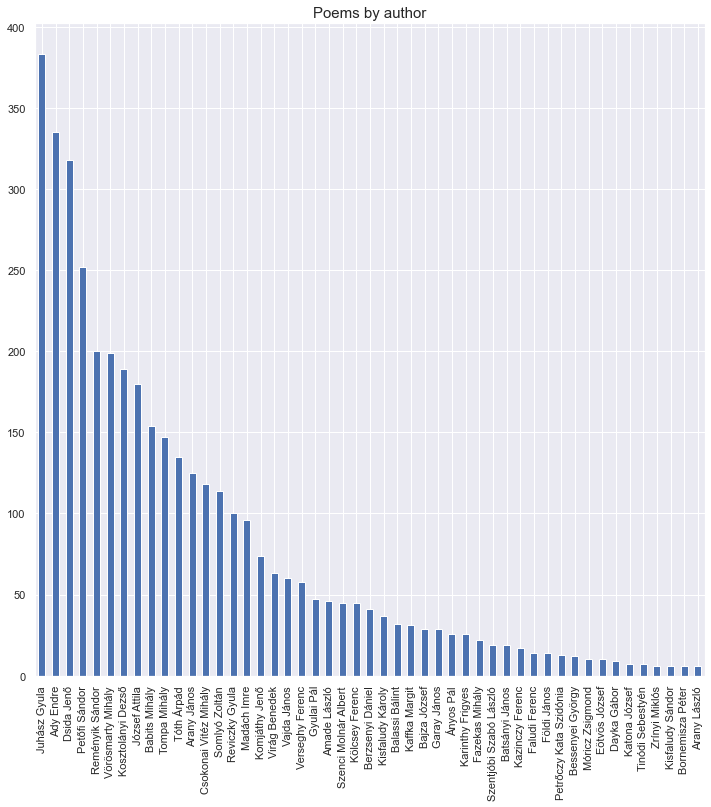

In [21]:
plt.figure(figsize=(12,12))
plt.title("Poems by author",fontsize=15)
df['author'].value_counts()[0:50].plot(kind='bar')

#### 2.2 Birth year column

I checked the distribution by birth year. Unfortunately the dataset is very unbalanced in terms of time coverage

<AxesSubplot:title={'center':'Poems by year'}, ylabel='Frequency'>

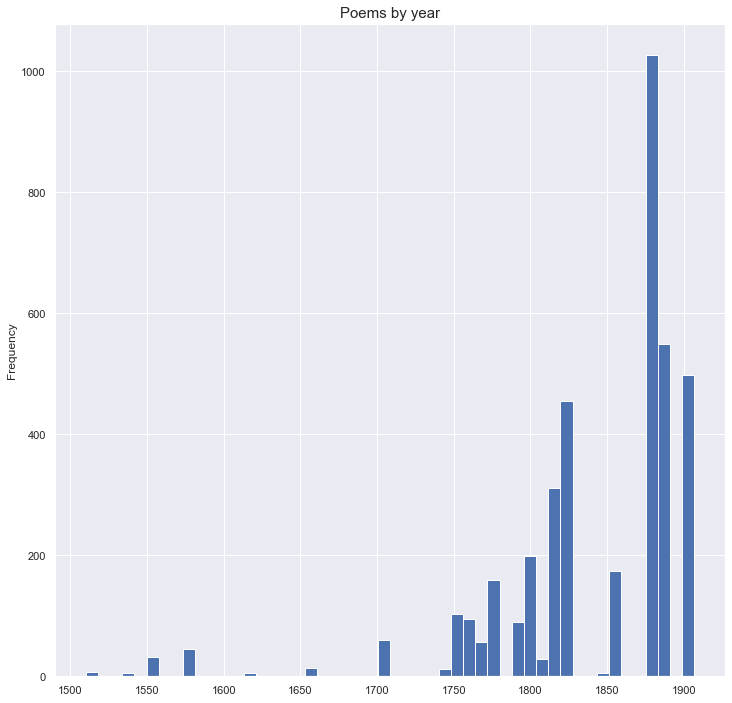

In [24]:
plt.figure(figsize=(12,12))
plt.title("Poems by year",fontsize=15)
df['birth'].plot(kind='hist', bins=50)

#### 2.3 Length

There are clearly soem long poems I need to get rid of

In [26]:
df['length'] = df["poem"].apply(lambda x: len(x))
df

,author,title,poem,birth,length
0,Juhász Gyula,Melankólia [1],A kicsiny élet mégis szép nagyon És akad néha ...,1883,587
1,Juhász Gyula,Betlehemi üzenet a vakoknak,"Testvéreim , egy látó küldi néktek Üdvözletül ...",1883,841
2,Juhász Gyula,Sírfölirat,Legjobb édesanya hamvai nyugszanak itten : Lel...,1883,85
3,Juhász Gyula,Rabság,E föld nekem csak tömlöcöm És végzetem vad por...,1883,556
4,Juhász Gyula,Emőd Tamásnak,"Hallgatsz s e csönd oly beszédes nekem , Elhal...",1883,363
...,...,...,...,...,...
3926,Arany László,AZ IRGALOM,"Mint purgatorium , kietlen , bús , setét , Hol...",1844,2005
3927,Arany László,KÉSŐN,"Már elnyit a tavasz , varázsa széled , Szép ál...",1844,521
3928,Arany László,TŰNŐDÉS,"Virrasztok árva lámpa mellett , Olyan nyomaszt...",1844,2548
3929,Arany László,A délibábok hőse,"Dante Mult évek emlékén el-elborongok , Az ifj...",1844,98796


In [28]:
df['length'].describe()

count    3487.000000
mean      715.268426
std       424.845609
min        26.000000
25%       422.000000
50%       613.000000
75%       940.000000
max      1999.000000
Name: length, dtype: float64

In [29]:
df = df[df['length'] < 2000]

<AxesSubplot:title={'center':'Poems by year'}, ylabel='Frequency'>

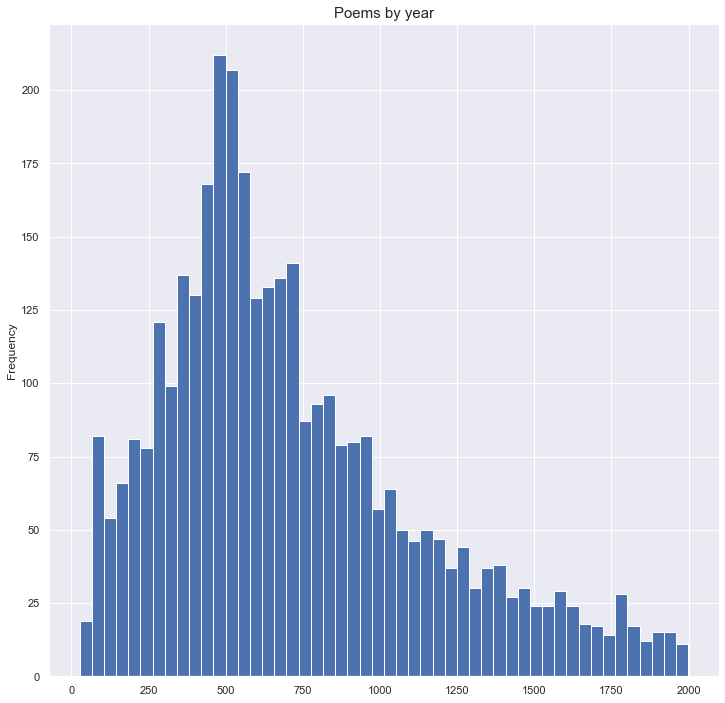

In [30]:
plt.figure(figsize=(12,12))
plt.title("Poems by year",fontsize=15)
df['length'].plot(kind='hist', bins=50)

### Question 1 - Sentiment analysis

In this chapter I will examine the sentiment in general for the whole sample, by time, and by author.
I tried to anwser the following 3 question:
- What is the general sentiment of Hungarian poetry?
- Which of our authors are the most cheerfull adn which ones arethe most gloomy?
- Is there a trend in time of sentiment changing?

The key challange here is that hungarian language has no lammetization and no sentiment analysis, or at least I did not find for python. So I needed to translate the poems into english and analyze their sentiment there. However this is not an easy task with poems that use uncommon hungarian words in an uncommon order. I planned to translate a cleaned version word by word, but the google translation algorythm has a daily limit on requests, so translating c.700,000 words individually was not an potion. Instead I did the following steps:


- Translating text to english: I used a google translator algorythm to translate in 2 batches: First I run the translation function on all the poems with a try-else function, and then I did a second round of translating the poems that were excluded in the first round due to response issues. I then merged the 2 dataframes

- Cleaning translation: I again had to clean the translated text. As I could not translate word-by-word, but the whole poem, the translation included a lot of stopwords in english. I also did lemmatization.

- Sentiment analysis: I used vader sentiment analysis to get the sentiment of each poem. 

In [31]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import time

#### Translating text to english

In [42]:
df_q1 = df
df_q1

,author,title,poem,birth,length
0,Juhász Gyula,Melankólia [1],A kicsiny élet mégis szép nagyon És akad néha ...,1883,587
1,Juhász Gyula,Betlehemi üzenet a vakoknak,"Testvéreim , egy látó küldi néktek Üdvözletül ...",1883,841
2,Juhász Gyula,Sírfölirat,Legjobb édesanya hamvai nyugszanak itten : Lel...,1883,85
3,Juhász Gyula,Rabság,E föld nekem csak tömlöcöm És végzetem vad por...,1883,556
4,Juhász Gyula,Emőd Tamásnak,"Hallgatsz s e csönd oly beszédes nekem , Elhal...",1883,363
...,...,...,...,...,...
3912,Zrínyi Miklós,ATILLA,"Isten haragjának én szelleti voltam , Mikor ez...",1620,314
3919,Bornemisza Péter,Énekecske gyermekek rengetésére,"Szenteltessék Uram az te szent neved , Dícsérj...",1535,1301
3923,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],"Én császár nem lennék , hogy annyit fáradnék ,...",1535,356
3924,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [1],"Az elefánt nagy , mégis megöletik ; az oroszlá...",1535,172


In [34]:
from googletrans import Translator
translator = Translator()

In [35]:
def text_translator(text):
    return translator.translate(text, dest="en", src="hu").text

Translating function on all poems

In [43]:
#translated_poem = []
#for poem in list(df_q1["poem"]):
#    try:
#        translated_poem.append(text_translator(poem))
#    except:
#        translated_poem.append("")
        
#len(translated_poem)

3487

In [45]:
#df_q1["poem_trans"] = translated_poem
#df_q1

,author,title,poem,birth,length,poem_trans
0,Juhász Gyula,Melankólia [1],A kicsiny élet mégis szép nagyon És akad néha ...,1883,587,The little life is pretty very and I sometimes...
1,Juhász Gyula,Betlehemi üzenet a vakoknak,"Testvéreim , egy látó küldi néktek Üdvözletül ...",1883,841,"My brethren, a visitor sends unto you, greeted..."
2,Juhász Gyula,Sírfölirat,Legjobb édesanya hamvai nyugszanak itten : Lel...,1883,85,Best Mother's Ashes rest here: his soul contin...
3,Juhász Gyula,Rabság,E föld nekem csak tömlöcöm És végzetem vad por...,1883,556,"So infinite rich in the world, my brothers and..."
4,Juhász Gyula,Emőd Tamásnak,"Hallgatsz s e csönd oly beszédes nekem , Elhal...",1883,363,"You listen to S silence so talkative for me, I..."
...,...,...,...,...,...,...
3912,Zrínyi Miklós,ATILLA,"Isten haragjának én szelleti voltam , Mikor ez...",1620,314,The anger of God was a breeze when I was in th...
3919,Bornemisza Péter,Énekecske gyermekek rengetésére,"Szenteltessék Uram az te szent neved , Dícsérj...",1535,1301,"Sacrificing Lord is your sacred name, a praise..."
3923,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],"Én császár nem lennék , hogy annyit fáradnék ,...",1535,356,I would not be an Emperor so I would be so tir...
3924,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [1],"Az elefánt nagy , mégis megöletik ; az oroszlá...",1535,172,"The elephant is large, yet kills;The lion is s..."


30 rows were not translated only. this is so few I will just drop these rows (1% of observations)

In [47]:
#df_q1[df_q1["poem_trans"] == ""]

,author,title,poem,birth,length,poem_trans
1053,Petőfi Sándor,HA A SÍRBAN MEGSZÁRADT...,Ha a sírban megszáradt szíveket Mind egy halom...,1823,121,
1456,Reményik Sándor,Az óriás,"Lefojtott álmok , lenyűgözött vágyak , Zöldből...",1890,1914,
1639,Vörösmarty Mihály,A „KÜLÖNC” FORDÍTÓJÁNAK,"Honnom , a hálátlan rég sírba taszíta , s nyug...",1800,101,
1660,Vörösmarty Mihály,(AKI MERÉSZ...),"Aki merész , csak az él , a gyávát tengeti hiv...",1800,51,
1675,Vörösmarty Mihály,(NŐ S ANYA NYÚGOSZIK ITT...),"Nő s anya nyúgoszik itt , házának gyásza s kes...",1800,99,
2257,Tompa Mihály,TÉLI ZÖLD.,"‘ Miért örűltök a tavasznak , Földnek virágai ...",1817,1892,
2354,Tompa Mihály,VIGASZTALÁS.,"Ha szép reményed , a Kétség alatt , S miatta s...",1817,207,
2485,Tóth Árpád,SÖTÉT SZÍN IZZIK...,"Sötét szín izzik , vékony vonal indul , Az ébr...",1886,141,
2598,Arany János,FALUSI MULATSÁG,Vígan fiúk ! húzd rá cigány ! Könnyítsünk a ne...,1817,1706,
2861,Reviczky Gyula,Tartsatok bűnbánatot!,Megromlott már a régi erkölcs . Egy kor veszőb...,1855,1953,


In [49]:
#df_q1 = df_q1[df_q1["poem_trans"] != ""]

In [50]:
# df_q1.to_csv("./df_q1_trans.csv", index=False)

final dataframe

In [51]:
df_q1 = pd.read_csv("./df_q1_trans.csv")
df_q1

,author,title,poem,birth,length,poem_trans
0,Juhász Gyula,Melankólia [1],A kicsiny élet mégis szép nagyon És akad néha ...,1883,587,The little life is pretty very and I sometimes...
1,Juhász Gyula,Betlehemi üzenet a vakoknak,"Testvéreim , egy látó küldi néktek Üdvözletül ...",1883,841,"My brethren, a visitor sends unto you, greeted..."
2,Juhász Gyula,Sírfölirat,Legjobb édesanya hamvai nyugszanak itten : Lel...,1883,85,Best Mother's Ashes rest here: his soul contin...
3,Juhász Gyula,Rabság,E föld nekem csak tömlöcöm És végzetem vad por...,1883,556,"So infinite rich in the world, my brothers and..."
4,Juhász Gyula,Emőd Tamásnak,"Hallgatsz s e csönd oly beszédes nekem , Elhal...",1883,363,"You listen to S silence so talkative for me, I..."
...,...,...,...,...,...,...
3470,Zrínyi Miklós,ATILLA,"Isten haragjának én szelleti voltam , Mikor ez...",1620,314,The anger of God was a breeze when I was in th...
3471,Bornemisza Péter,Énekecske gyermekek rengetésére,"Szenteltessék Uram az te szent neved , Dícsérj...",1535,1301,"Sacrificing Lord is your sacred name, a praise..."
3472,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],"Én császár nem lennék , hogy annyit fáradnék ,...",1535,356,I would not be an Emperor so I would be so tir...
3473,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [1],"Az elefánt nagy , mégis megöletik ; az oroszlá...",1535,172,"The elephant is large, yet kills;The lion is s..."


#### Cleaning translated text

The translation instered stoppwords into the text, so I need to clean and elmmatize the english version again. Here I used lammatiztion

In [52]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [53]:
def text_preprocesser_2(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [word for word in tokens if len(word)>=3]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [54]:
df_q1["poem_trans_clean"] = df_q1["poem_trans"].apply(lambda x: text_preprocesser_2(x))
df_q1 = df_q1[["author","birth","length","poem","poem_trans", "poem_trans_clean"]]
df_q1

,author,birth,length,poem,poem_trans,poem_trans_clean
0,Juhász Gyula,1883,587,A kicsiny élet mégis szép nagyon És akad néha ...,The little life is pretty very and I sometimes...,little life pretty sometimes little good day.a...
1,Juhász Gyula,1883,841,"Testvéreim , egy látó küldi néktek Üdvözletül ...","My brethren, a visitor sends unto you, greeted...",brother visitor sends unto greeted today tearf...
2,Juhász Gyula,1883,85,Legjobb édesanya hamvai nyugszanak itten : Lel...,Best Mother's Ashes rest here: his soul contin...,best mother ash rest soul continuing virast ke...
3,Juhász Gyula,1883,556,E föld nekem csak tömlöcöm És végzetem vad por...,"So infinite rich in the world, my brothers and...",infinite rich world brother sister virgin star...
4,Juhász Gyula,1883,363,"Hallgatsz s e csönd oly beszédes nekem , Elhal...","You listen to S silence so talkative for me, I...",listen silence talkative silence lonely nights...
...,...,...,...,...,...,...
3470,Zrínyi Miklós,1620,314,"Isten haragjának én szelleti voltam , Mikor ez...",The anger of God was a breeze when I was in th...,anger god breeze world weapon drowned sword sw...
3471,Bornemisza Péter,1535,1301,"Szenteltessék Uram az te szent neved , Dícsérj...","Sacrificing Lord is your sacred name, a praise...",sacrificing lord sacred name praise cheek give...
3472,Bornemisza Péter,1535,356,"Én császár nem lennék , hogy annyit fáradnék ,...",I would not be an Emperor so I would be so tir...,would emperor would tired would shake would hé...
3473,Bornemisza Péter,1535,172,"Az elefánt nagy , mégis megöletik ; az oroszlá...","The elephant is large, yet kills;The lion is s...",elephant large yet kill lion strong yet convin...


#### Sentiment analysis of translation

In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [57]:
df_q1['polarity_score']=df_q1['poem_trans_clean'].apply(lambda x:sentiment.polarity_scores(str(x))['compound'])

In [58]:
df_q1['neutral']=df_q1['poem_trans_clean'].apply(lambda x:sentiment.polarity_scores(str(x))['neu'])

In [59]:
df_q1['negative']=df_q1['poem_trans_clean'].apply(lambda x:sentiment.polarity_scores(str(x))['neg'])

In [60]:
df_q1['positive']=df_q1['poem_trans_clean'].apply(lambda x:sentiment.polarity_scores(str(x))['pos'])

#### Lets check the most positive poem

Yepp, looks pretty positive

In [74]:
df_q1.sort_values("positive", ascending=False)["poem"][3425]

'Üdvözlégy jó Jézus , egyetlen szerelmem , Üdvözlégy megváltóm , édes segedelmem , Üdvözlégy , üdvözlégy , óh én üdvösségem , Üdvözlégy Szép Jézus , édes reménységem .'

In [75]:
df_q1.sort_values("positive", ascending=False)["poem_trans"][3425]

'Welcome good Jesus, my sole love, welcoming my redeemer, sweet sister, greeting, welcome, oh my salvation, greeting beautiful Jesus, my sweet hope.'

In [76]:
df_q1.sort_values("positive", ascending=False)["poem_trans_clean"][3425]

'welcome good jesus sole love welcoming redeemer sweet sister greeting welcome salvation greeting beautiful jesus sweet hope'

#### Lets check the most negative one

looks pretty sad

In [78]:
df_q1.sort_values("negative", ascending=False)["poem"][355]

'Meghalni milyen szomorú lehet , Mikor mienk még mind a kikelet . Mikor a rózsák legszebb kora van : Meghalni , elmenni magányosan ! Meghalni milyen szomorú lehet , Mikor a köd már küldi a telet , Mikor az őszirózsa oda van : Meghalni , elmenni magányosan ! Mindegy ! Ha nap ég , ha köd borong , Szomorúak voltunk vagy boldogok , Későn , korán , - keserű bárhogyan : Meghalni , elmenni magányosan !'

In [79]:
df_q1.sort_values("negative", ascending=False)["poem_trans"][355]

'To die how sad it may be when Mienk is all the Kicking.When the roses are the most beautiful age: to die, leave lonely!To die how sad it may be when the fog is already sending the winter when the autumn is there: die, to leave lonely!Never mind !'

In [81]:
df_q1.sort_values("negative", ascending=False)["poem_trans_clean"][355]

'die sad may mienk kicking.when rose beautiful age die leave lonely die sad may fog already sending winter autumn die leave lonely never mind'

### Anwsering Q1 questions

#### What is the general sentiment of Hungarian poetry?

The majority of the poems in the sample have 0.152 negative and a 0.265 positive sentiment score. The positive sentiment is 70% higer than the negative sentiment, meaning the poems are more positive

In [86]:
negative_avg = df_q1["negative"].mean()
positive_avg = df_q1["positive"].mean()
print(negative_avg)
print(positive_avg)
positive_avg / negative_avg

0.15435942446043188
0.2620126618705037


1.6974192718480068

however, this result can be skewed by having a few authors with a lot of positive poems.

Checking the weighted average we can see that the picture is even more positive

In [87]:
negative_w_avg = df_q1.groupby("author")["negative"].mean().mean()
positive_w_avg = df_q1.groupby("author")["positive"].mean().mean()
print(negative_w_avg)
print(positive_w_avg)
positive_w_avg / negative_w_avg

0.1579340339959135
0.28360895039093204


1.795743091057057

### Who are the most positive or negative authors?

almost all authors have more positive sentiment than negative sentiment poems

In [106]:
# pivot by author

t1 = df_q1.groupby("author")["negative"].mean().reset_index()
t2 = df_q1.groupby("author")["positive"].mean().reset_index()
df_q1_pivot_1 = pd.merge(t1,t2)
df_q1_pivot_1["sentiment"] = df_q1_pivot_1["negative"] > df_q1_pivot_1["positive"]
df_q1_pivot_1["sentiment"] = df_q1_pivot_1["sentiment"].apply(lambda x: "positive" if x==False else "negative")
df_q1_pivot_1.sort_values(['positive'], ascending=[False])

,author,negative,positive,sentiment
3,Arany László,0.258000,0.403000,positive
37,Szenci Molnár Albert,0.145946,0.397595,positive
32,Petrőczy Kata Szidónia,0.218444,0.383667,positive
6,Balassi Bálint,0.183000,0.379792,positive
7,Batsányi János,0.157071,0.355143,positive
8,Berzsenyi Dániel,0.113842,0.353474,positive
1,Amade László,0.201318,0.348841,positive
15,Faludi Ferenc,0.116000,0.348182,positive
38,Szentjóbi Szabó László,0.114389,0.346222,positive
19,Gyulai Pál,0.154098,0.343195,positive


In the matrix the bottom right corner represents the most positive and the top left vcorner the most negative authors. 
Faludy Ferenc and Petőczy Kata are the most positive ones, while Földi János seems to be the most negative one. 

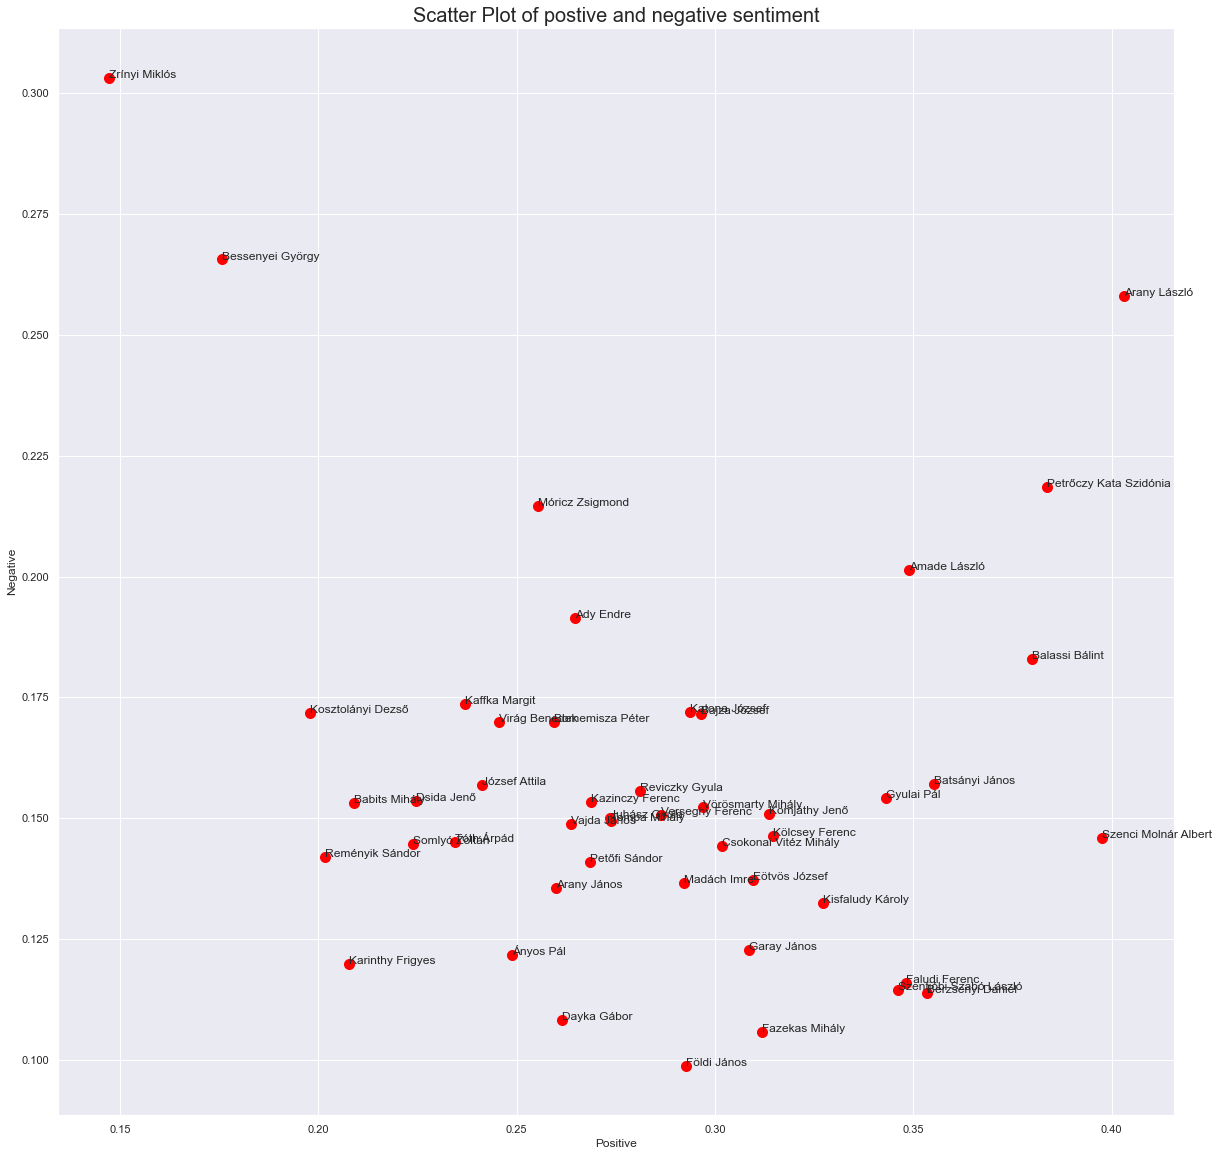

In [107]:
import numpy as np
import matplotlib.pyplot as plt

X = df_q1_pivot_1["positive"]
Y = df_q1_pivot_1["negative"]

annotations=df_q1_pivot_1["author"]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.title("Scatter Plot of postive and negative sentiment",fontsize=20)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

### Sentiment trand through time

Based on the uneven data points in time, it was only possible to check sentiments by centuries before 1700, and every 50 years from 1700 to 1950. I added 20 years to the date of birth, to better place the author in the century where he was likely to write most of his work.

In [155]:
# pivot by century
df_q1["century"] = df_q1["birth"].apply(lambda x: 
                                       "1500-1600" if x+20 <= 1600
                                       else ("1600-1700" if x+20 <= 1700 
                                             else ("1700-1750" if x+20 <=1750 
                                                   else ("1750-1800" if x+20 <=1800 
                                                        else ("1800-1850" if x+20 <= 1850 
                                                              else ("1850-1900" if x+20 <= 1900 
                                                                  else ("1900-1950" if x+20 <= 1950 
                                                                       else ("1950-2000" if x+20 <= 2000
                                                                            else "xxx"))))))))


We can see that the positive sentiment decreased by time, while the negative fluctuated

In [156]:
# pivot by author

t3 = df_q1.groupby("century")["negative"].mean().reset_index()
t4 = df_q1.groupby("century")["positive"].mean().reset_index()
df_q1_pivot_1 = pd.merge(t3,t4)
df_q1_pivot_1.sort_values(['positive'], ascending=[False])

,century,negative,positive
0,1500-1600,0.160969,0.384437
2,1700-1750,0.184255,0.348709
1,1600-1700,0.244538,0.310923
3,1750-1800,0.141873,0.293355
4,1800-1850,0.144853,0.285516
5,1850-1900,0.179824,0.272452
6,1900-1950,0.152039,0.231495


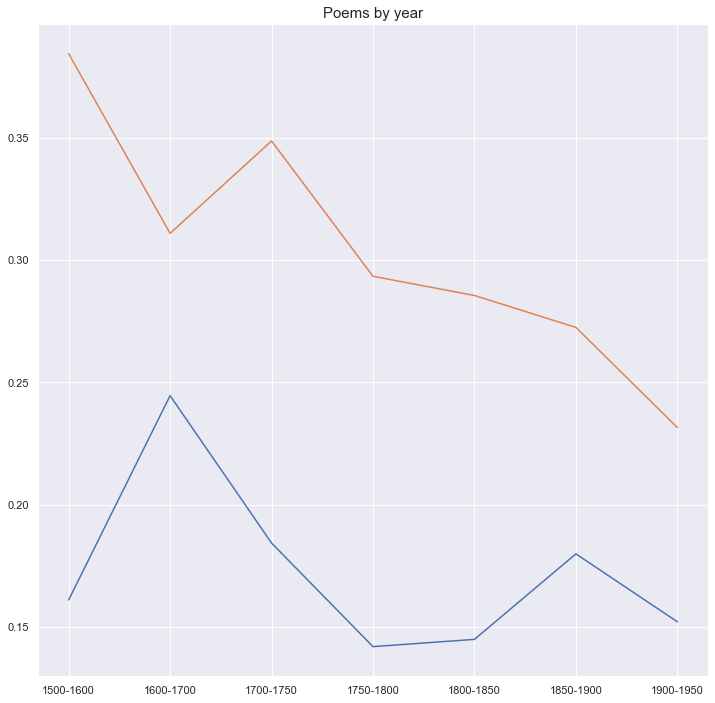

In [172]:
plt.figure(figsize=(12,12))
plt.title("Poems by year",fontsize=15)
plt.plot(
    df_q1_pivot_1['century'],
    df_q1_pivot_1['negative'],
    df_q1_pivot_1['positive']
)

### Q2: Classification of poetry by poets using Naive_Bayes

I will select the 3 authors with the most poems for classification analysis

In [173]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [174]:
authors = ("Juhász Gyula", "Ady Endre", "Dsida Jenő")

In [175]:
df = pd.read_csv("./talalatok.tsv", sep='\t')
df = pd.DataFrame(df)
df = df.rename(columns={"Szerző":"author", "Műcím":"title", "Webcím":"url"})
df.head(5)

,author,title,url
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325


In [176]:
df_q2 = df[(df.author == "Juhász Gyula") | (df.author == "Ady Endre") | (df.author == "Dsida Jenő")]
df_q2['author'].value_counts()

Juhász Gyula    1278
Ady Endre       1116
Dsida Jenő      1060
Name: author, dtype: int64

I scraped the text of the poems based on the given url

In [119]:
# poems = []
# poem = []

# for url in df_q2["url"]:
#    poem=[]
#    print(url)
#    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
#    for word in soup.find_all('span', class_='word'):
#        poem.append(word.text)
#    poems.append(" ".join(poem))

In [120]:
# df_q2["poem"] = poems
# df_q2.to_csv('./df_q2.csv', index=False)

#### Checking the data

In [177]:
df_q2 = pd.read_csv("./df_q2.csv")
df_q2

,author,title,url,poem
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858,"Mikor megláttalak , új életre keltem , Kínos é..."
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458,"Jó fiam , ma minden magyar elválik , Ki messze..."
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304,"Oszlik lelkemnek barna gyásza : Nagy , fehér f..."
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636,"Halkult , rejtő és becéző szavak , Ti akkor is..."
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325,Ajándékodból egy csipetnyi Maradt az alkonyi ó...
...,...,...,...,...
3449,Juhász Gyula,Zászlók,https://verskorpusz.elte-dh.hu/view.php?id=9251,"A múzeumban vannak régi zászlók , Csukott szár..."
3450,Juhász Gyula,Zene,https://verskorpusz.elte-dh.hu/view.php?id=8824,"Az ember , amíg fiatal , erős , Úgy véli , hog..."
3451,Juhász Gyula,"Zrinyi, a költő",https://verskorpusz.elte-dh.hu/view.php?id=8564,Sötéten csillogó bogyószemed Mély századok éjé...
3452,Juhász Gyula,Zsolozsma [1],https://verskorpusz.elte-dh.hu/view.php?id=9512,"Szeretlek téged , rejtelmes szemű , Titokzatos..."


In [178]:
df_q2["author"].value_counts()

Juhász Gyula    1278
Ady Endre       1116
Dsida Jenő      1060
Name: author, dtype: int64

There are some very long poems which I will exclude from my analysis for pratical reasons (above the 75% percentile, which is 1146 words)

In [179]:
df_q2['length'] = df_q2['poem'].apply(len)
df_q2.length.describe()

count     3454.000000
mean       680.967863
std        668.786786
min         40.000000
25%        426.000000
50%        544.500000
75%        747.000000
max      16995.000000
Name: length, dtype: float64

In [180]:
df_q2.sort_values(['length'], ascending=[False]).head(5)

,author,title,url,poem,length
1691,Dsida Jenő,Kóborló délután kedves kutyámmal,https://verskorpusz.elte-dh.hu/view.php?id=3938,"Szép farkaskutya , Tinti , örülj ! Leakasztom ...",16995
1800,Dsida Jenő,Miért borultak le az angyalok Viola előtt,https://verskorpusz.elte-dh.hu/view.php?id=3796,"Bocsánat , olvasóm , ki mostig üldögéltél újsá...",14853
1816,Dsida Jenő,Mirtha,https://verskorpusz.elte-dh.hu/view.php?id=3013,"Vén , szürke holló mondta el nekem , gubbaszko...",8499
1935,Dsida Jenő,Psalmus Hungaricus,https://verskorpusz.elte-dh.hu/view.php?id=3730,Vagy félezernyi dalt megírtam s e szót : magya...,7791
1649,Dsida Jenő,Kalendárium szonettekben,https://verskorpusz.elte-dh.hu/view.php?id=3252,"Barát vagyok , fiatal , vézna , ványadt : Halk...",7154


In [181]:
df_q2 = df_q2[df_q2["length"] < 2000]
df_q2.length.describe()

count    3379.000000
mean      610.424978
std       303.035483
min        40.000000
25%       423.000000
50%       539.000000
75%       734.500000
max      1999.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Frequency'>

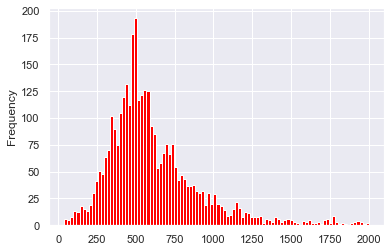

In [182]:
df_q2['length'].plot(bins=100, kind='hist', color='red')

array([[<AxesSubplot:title={'center':'Ady Endre'}>,
        <AxesSubplot:title={'center':'Dsida Jenő'}>],
       [<AxesSubplot:title={'center':'Juhász Gyula'}>, <AxesSubplot:>]],
      dtype=object)

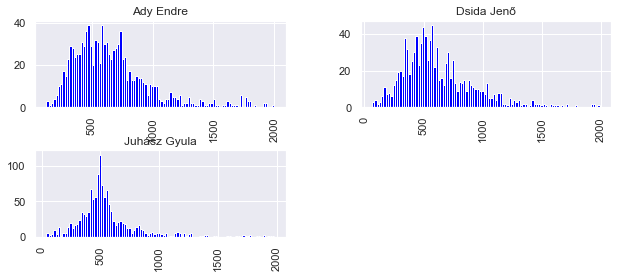

In [183]:
df_q2.hist(column='length', by='author',color='blue', bins=100, figsize=(10,4))

#### Text processing

In [184]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [185]:
stopwords = stopwords.words('hungarian')# Show the vector of stop words

In [186]:
# adding custom stopwords
custom_words = ["ó", "kis", "en", "te","ot","előtt","ha", "mi","ti","ők", "őket", "oly"]
stopwords = stopwords + custom_words
stopwords

['a',
 'ahogy',
 'ahol',
 'aki',
 'akik',
 'akkor',
 'alatt',
 'által',
 'általában',
 'amely',
 'amelyek',
 'amelyekben',
 'amelyeket',
 'amelyet',
 'amelynek',
 'ami',
 'amit',
 'amolyan',
 'amíg',
 'amikor',
 'át',
 'abban',
 'ahhoz',
 'annak',
 'arra',
 'arról',
 'az',
 'azok',
 'azon',
 'azt',
 'azzal',
 'azért',
 'aztán',
 'azután',
 'azonban',
 'bár',
 'be',
 'belül',
 'benne',
 'cikk',
 'cikkek',
 'cikkeket',
 'csak',
 'de',
 'e',
 'eddig',
 'egész',
 'egy',
 'egyes',
 'egyetlen',
 'egyéb',
 'egyik',
 'egyre',
 'ekkor',
 'el',
 'elég',
 'ellen',
 'elõ',
 'elõször',
 'elõtt',
 'elsõ',
 'én',
 'éppen',
 'ebben',
 'ehhez',
 'emilyen',
 'ennek',
 'erre',
 'ez',
 'ezt',
 'ezek',
 'ezen',
 'ezzel',
 'ezért',
 'és',
 'fel',
 'felé',
 'hanem',
 'hiszen',
 'hogy',
 'hogyan',
 'igen',
 'így',
 'illetve',
 'ill.',
 'ill',
 'ilyen',
 'ilyenkor',
 'ison',
 'ismét',
 'itt',
 'jó',
 'jól',
 'jobban',
 'kell',
 'kellett',
 'keresztül',
 'keressünk',
 'ki',
 'kívül',
 'között',
 'közül',
 'lega

In [187]:
def remove_punct_tokenize(text):
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()   
    return text.split()  

def remove_stopwords(text):
    clean_stopwords=""
    for element in remove_punct_tokenize(text):
        if element not in stopwords:
            clean_stopwords = clean_stopwords + " "+ element
    return clean_stopwords.strip()

In [188]:
df_q2['poem'] = df_q2['poem'].apply(remove_stopwords)

C:\Users\Dani\AppData\Local\Temp/ipykernel_13940/1620434100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2['poem'] = df_q2['poem'].apply(remove_stopwords)


In [189]:
df_q2 = df_q2[["author","poem"]]
df_q2.head(5)

,author,poem
0,Ady Endre,megláttalak életre keltem kínos élet zordon mu...
1,Ady Endre,fiam ma magyar elválik messze messzebb magánál...
2,Ady Endre,oszlik lelkemnek barna gyásza fehér fényben jö...
3,Ady Endre,halkult rejtő becéző szavak is mellette leszte...
4,Ady Endre,ajándékodból csipetnyi maradt alkonyi órákra u...


#### Get bow vectorizer

In [134]:
# !pip install sklearn

In [190]:
from sklearn.feature_extraction.text import CountVectorizer

In [191]:
#CountVectorizer will convert text into token counts
bow_transformer = CountVectorizer()

In [192]:
bow_transformer = CountVectorizer(preprocessor = remove_stopwords).fit(df_q2['poem'])

#### Transform poems

In [193]:
data_bow = bow_transformer.transform(df_q2['poem'])

#### Tf-IDF transformation

In [194]:
from sklearn.feature_extraction.text import TfidfTransformer

In [195]:
tfidf_transformer = TfidfTransformer().fit(data_bow)

In [196]:
data_tfidf = tfidf_transformer.transform(data_bow)
print (data_tfidf.shape)

(3379, 53749)


In [197]:
data_tfidf

<3379x53749 sparse matrix of type '<class 'numpy.float64'>'
	with 184024 stored elements in Compressed Sparse Row format>

#### Naive Bayes Classifier

In [198]:
from sklearn.naive_bayes import MultinomialNB

In [199]:
author_detect_model = MultinomialNB()

#### Train test split

In [200]:
from sklearn.model_selection import train_test_split
poem_train, poem_test, author_train, author_test = train_test_split(df_q2["poem"], df_q2["author"], test_size=0.2, random_state=1, stratify=df_q2['author'])

In [201]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
#create pipeline
pipeline = Pipeline([
    ('tfidf', CountVectorizer(preprocessor = remove_stopwords )),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  #Naive Bayes classifier
])

In [202]:
pipeline.fit(poem_train, author_train)
predictions = pipeline.predict(poem_test)

Results show an 80-91% accuracy for the authors. This is pretty good, given that the benchmark random classification would have a 33% accuracy

In [148]:
from sklearn.metrics import classification_report
print (classification_report(author_test,  predictions))

              precision    recall  f1-score   support

   Ady Endre       0.91      0.80      0.85       202
  Dsida Jenő       0.92      0.79      0.85       194
Juhász Gyula       0.80      0.96      0.87       246

    accuracy                           0.86       642
   macro avg       0.87      0.85      0.86       642
weighted avg       0.87      0.86      0.86       642



In [203]:
from sklearn.metrics import confusion_matrix
#tn, fp, fn, tp = confusion_matrix(label_test,predictions).ravel()
confusion_matrix(author_test, predictions)

array([[181,  16,  21],
       [ 12, 166,  26],
       [  7,   3, 244]], dtype=int64)

I made a dataframe from the test test and the predicted labels

In [204]:
test = pd.DataFrame(list(zip(poem_test,author_test, predictions)), columns=['poem','author', 'prediction'])
test["difference"] = test["author"] == test["prediction"] 

In [162]:
test

,poem,author,prediction,difference
0,gyermekek játszadoznak déli sugaras utcán belé...,Ady Endre,Ady Endre,True
1,szerelmünk hidd bárki szeretné hinni édes édes...,Dsida Jenő,Ady Endre,False
2,magyar éjben fölzokognak siralmaid véres száza...,Juhász Gyula,Juhász Gyula,True
3,semmirevalónak gácsnak svábnak zsidónak grádic...,Ady Endre,Ady Endre,True
4,elmúlok szelíden álom följárok bús téli éjszak...,Juhász Gyula,Juhász Gyula,True
...,...,...,...,...
637,fáradt karokkal kesergőn hideg síneket szorito...,Ady Endre,Ady Endre,True
638,halottak halottak bennem künnkünn szerteszéjje...,Ady Endre,Ady Endre,True
639,istenem földben fűben kőben bántsuk egymást mo...,Ady Endre,Ady Endre,True
640,búsult csüggeteg árva adtam magam paráznaságra...,Ady Endre,Ady Endre,True


In [206]:
test["difference"].value_counts()

True     591
False     85
Name: difference, dtype: int64

Results by author show that Juhász Gyula could be classified the best

<AxesSubplot:xlabel='author', ylabel='count'>

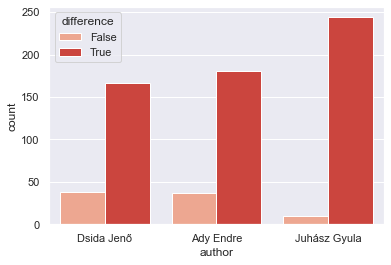

In [207]:
sns.countplot(x='author', hue="difference", data=test, palette="Reds")